<div align="center">
<font size="5">__Notebook to go step by step in the selection/reduction/calibration of DL0 data to DL1__</font>
<br><br>

<font size="4">
    **Some imports...**

In [233]:
from ctapipe.utils import get_dataset_path
from ctapipe.io import event_source
from ctapipe.io.eventseeker import EventSeeker

<font size="4">
    **Get the origin file with dl0 data which is a simtelarray file**

In [234]:
input_filename=get_dataset_path('gamma_test_large.simtel.gz')
#input_filename="/home/queenmab/DATA/LST1/Gamma/gamma_20deg_0deg_run8___cta-prod3-lapalma-2147m-LaPalma-FlashCam.simtel.gz"

<font size="4">
    **Get the data events into a ctapipe event container. We are only interested in LST1 events**

In [235]:
allowed_tels = {1}
source = event_source(input_filename)
source.allowed_tels = allowed_tels

<font size="4">
    **Take a look at the event container**

In [236]:
seeker =  EventSeeker(source)
event = seeker[2]
event

ctapipe.io.containers.DataContainer:
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                          mc.*: Monte-Carlo data
                    mcheader.*: Monte-Carlo run header data
                        trig.*: central trigger information
                         count: number of events processed
                        inst.*: instrumental information (deprecated
                   pointing[*]: Telescope pointing positions

In [237]:
event.r0

ctapipe.io.containers.R0Container:
                        obs_id: observation ID
                      event_id: event id number
                tels_with_data: list of telescopes with data
                        tel[*]: map of tel_id to R0CameraContainer

In [238]:
event.r0.tel

Map(ctapipe.io.containers.R0CameraContainer,
    {8: ctapipe.io.containers.R0CameraContainer:
                       trigger_time: Telescope trigger time, start of waveform
                                     readout, None for MCs
                       trigger_type: camera's event trigger type if applicable
                       num_trig_pix: Number of trigger groups (sectors) listed
                        trig_pix_id: pixels involved in the camera trigger
                              image: numpy array containing integrated ADC data
                                     (n_channels x n_pixels) DEPRECATED
                           waveform: numpy array containing ADC samples(n_channels x
                                     n_pixels, n_samples)
                        num_samples: number of time samples for telescope,
     1: ctapipe.io.containers.R0CameraContainer:
                       trigger_time: Telescope trigger time, start of waveform
                                     

<font size="4">
    **Get the waveform data**

In [239]:
data = event.r0.tel[1].waveform
data.shape


(2, 1855, 30)

The waveform is a matrix, has 30 samples in each of the 1855 pixels, for 2 gains. 

<font size="4">
**We can plot the waveforms and have an idea of their shapes.**

Lame loop to find a pixel with signal: 

In [240]:
maxvalue=0
for pixel in enumerate(data[0]):
    maxsample = max(pixel[1])
    if maxsample > maxvalue:
        maxvalue = maxsample
        pixelwithsignal = pixel[0]

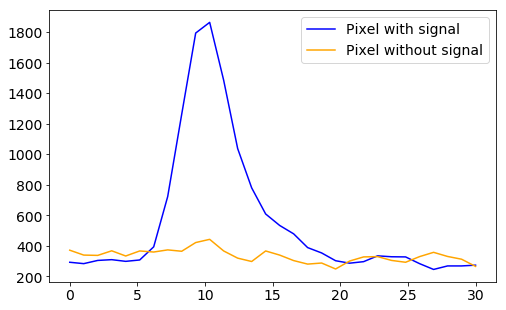

In [241]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 14
nsamples = data.shape[2]
sample = np.linspace(0,30,nsamples)
plt.plot(sample,data[0][pixelwithsignal],label="Pixel with signal",color =  "blue")
plt.plot(sample,data[0][0],label="Pixel without signal", color = "orange")
plt.legend()

<font size="4">
    **Get the pedestal, which is is the average (for pedestal events) of the *sum* of all samples, from sim_telarray**

In [242]:
ped = event.mc.tel[1].pedestal
ped.shape

(2, 1855)

Each pixel has its pedestal for the two gains.

<font size="4">
    **Correct the pedestal (np.atleast_3d function converts 2D to 3D matrix)**

In [243]:
pedcorrectedsamples = data - np.atleast_3d(ped) / nsamples
pedcorrectedsamples.shape

(2, 1855, 30)

<font size="4">
    **We can now compare the corrected waveforms with the previous ones**

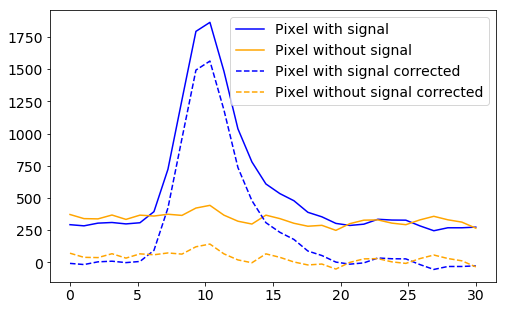

In [244]:
plt.plot(sample,data[0][pixelwithsignal],label="Pixel with signal",color="blue")
plt.plot(sample,data[0][0],label="Pixel without signal",color="orange")
plt.plot(sample,pedcorrectedsamples[0][pixelwithsignal],label="Pixel with signal corrected",color="blue",linestyle="--")
plt.plot(sample,pedcorrectedsamples[0][0],label="Pixel without signal corrected",color="orange",linestyle="--")
plt.legend()

<font size="4">
    **We must now find the peak in the waveform and do the integration to extract the charge in the pixel**

In [245]:
from ctapipe.image.charge_extractors import LocalPeakIntegrator

In [246]:
integrator = LocalPeakIntegrator(None, None)                                                                                                        
integration, peakpos, window = integrator.extract_charge(pedcorrectedsamples)

In [247]:
integration.shape, peakpos.shape, window.shape

((2, 1855), (2, 1855), (2, 1855, 30))

Integration gives the value of the charge

In [248]:
integration[0][0],integration[0][pixelwithsignal]

(486.20004, 6838.51)

Peakpos gives the position of the peak (in which sample it falls)

In [249]:
peakpos[0][0],peakpos[0][pixelwithsignal]

(10, 10)

window gives the number of samples used for the integration

In [250]:
window[0][0],window[0][pixelwithsignal]
sample[window[0][0]]

array([ 7.24137931,  8.27586207,  9.31034483, 10.34482759, 11.37931034,
       12.4137931 , 13.44827586])

<font size="4">
    **We can plot these positions on top of the waveform and decide if the integration and peak identification has been correct**

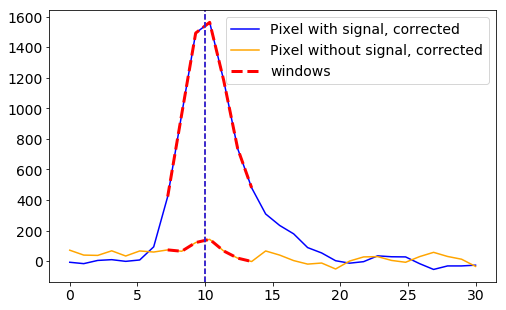

In [251]:
import matplotlib.patches as patches
plt.plot(sample,pedcorrectedsamples[0][pixelwithsignal],label="Pixel with signal, corrected",color="blue")
plt.plot(sample,pedcorrectedsamples[0][0],label="Pixel without signal, corrected",color="orange")
plt.plot(sample[window[0][0]],pedcorrectedsamples[0][0][window[0][0]],
         color="red",label="windows",linewidth=3,linestyle="--")
plt.plot(sample[window[0][pixelwithsignal]],pedcorrectedsamples[0][pixelwithsignal][window[0][pixelwithsignal]],
         color="red",linewidth=3,linestyle="--")
plt.axvline(peakpos[0][0],linestyle="--",color="orange")
plt.axvline(peakpos[0][pixelwithsignal],linestyle="--",color="blue")
plt.legend()

<font size="4">
    **Finally we must convert the charge from digital counts to photoelectrons**

In [252]:
signals = integration.astype(float)                                                                                                                 
dc2pe = event.mc.tel[1].dc_to_pe  # numgains * numpixels
signals *= dc2pe

<font size="4">
    **And fill the DL1 containers**

In [253]:
event.dl1.tel[1].image = signals                                                                                                         
event.dl1.tel[1].peakpos = peakpos
event.dl1.tel[1]

ctapipe.io.containers.DL1CameraContainer:
                         image: np array of camera image, after waveform
                                integration (N_pix)
                  gain_channel: boolean numpy array of which gain channel was
                                used for each pixel in the image
             extracted_samples: numpy array of bools indicating which samples
                                were included in the charge extraction as a
                                result of the charge extractor chosen.
                                Shape=(nchan, npix, nsamples).
                       peakpos: numpy array containing position of the peak as
                                determined by the peak-finding algorithm for
                                each pixel
                       cleaned: numpy array containing the waveform after
                                cleaning

<font size="4">
    **Say hello to our shower!**

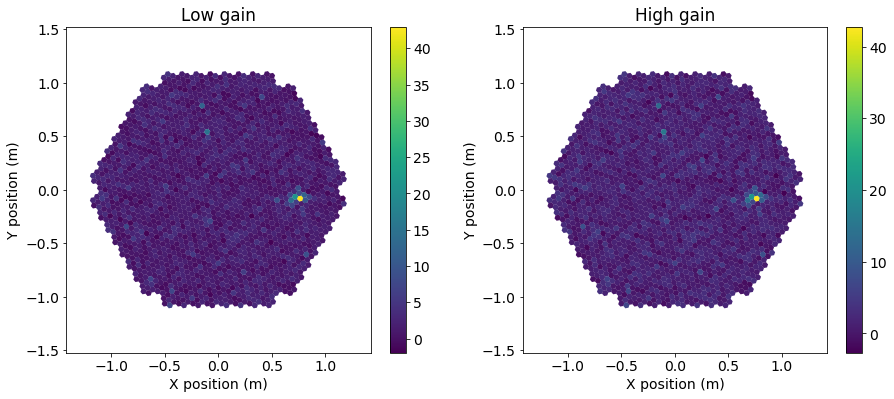

In [254]:
from ctapipe.visualization import CameraDisplay
camera = event.inst.subarray.tel[1].camera
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 14
plt.subplot(1,2,1)
disp = CameraDisplay(camera,title="Low gain")
disp.add_colorbar()
disp.image = signals[0]
plt.subplot(1,2,2)
disp = CameraDisplay(camera,title = "High gain")
disp.add_colorbar()
disp.image = signals[1]

<font size="4">
    **Time to do the cleaning**

In [255]:
from ctapipe.image import hillas_parameters, hillas_parameters_2, tailcuts_clean
cleaning_method = tailcuts_clean
cleaning_parameters = {'boundary_thresh': 3,                                                                                                            
                       'picture_thresh': 6,                                                                                                             
                       'keep_isolated_pixels': False,                                                                                                   
                       'min_number_picture_neighbors': 1                                                                                                
                       }

In [256]:
signal = signals[0]
signal_pixels = cleaning_method(camera,signal,**cleaning_parameters)

We are only using the first gain channel

In [257]:
image = signal                                                                                                                          
image[~signal_pixels] = 0

<font size="4">
    **Let's take a look at the clean and shiny image**

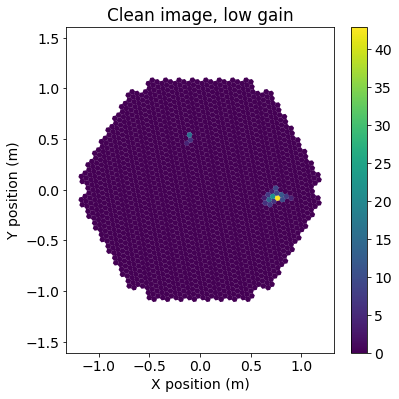

In [258]:
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['font.size'] = 14
disp = CameraDisplay(camera,title = "Clean image, low gain")
disp.image = image
disp.add_colorbar()

<font size="4">
    **Now we can calculate the hillas parameters**

In [259]:
hillas = hillas_parameters(camera,image)
hillas
hillas.intensity

189.12746973957064

<font size="4">
    **And plot them over the image**

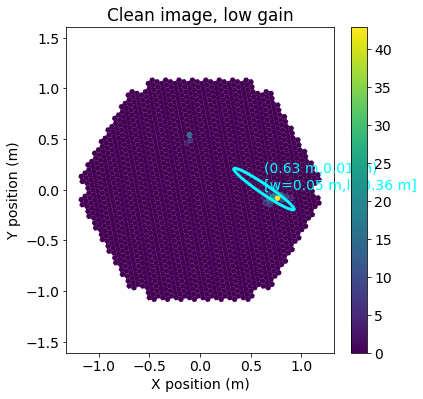

In [260]:
disp = CameraDisplay(camera,title = "Clean image, low gain")
disp.add_colorbar()
disp.image = image
disp.overlay_moments(hillas, color='cyan', linewidth=3)

<font size="4">
    **Also we can calculate the timing parameters**

In [261]:
from ctapipe.image import timing_parameters as time
timepars = time.timing_parameters(camera, image, peakpos[0], hillas)
timepars

ctapipe.io.containers.TimingParametersContainer:
                         slope: Slope of arrival times along main shower axis
                     intercept: intercept of arrival times along main shower
                                axis

In [262]:
timepars.slope,timepars.intercept

(<Quantity -8.62797387 1 / m>, 11.244153594775515)